<a href="https://colab.research.google.com/github/denizstij/Bitgrit_NFT_Price_Prediction/blob/main/Bitgrit_NFT_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
from catboost import Pool, CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
import pandas as pd
import numpy as np
import random
import os
import datetime

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder


import lightgbm as lgb

In [4]:
pd.set_option('display.width', 1000)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
dataset_path='/content/drive/MyDrive/Colab Notebooks/BritGritNFTPrices/dataset/'


In [6]:
def seed_everything(seed=55):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
MY_SEED=55
#MAX_SALE=1500
MAX_SALE=1
seed_everything(MY_SEED)

# Load Data

In [8]:
df_cols=pd.read_csv(dataset_path+'collections.csv')
df_cols_stats=pd.read_csv(dataset_path+'collections_twitter_stats.csv')
df_all_train=pd.read_csv(dataset_path+'nfts_train.csv')
df_submission=pd.read_csv(dataset_path+'submission_format.csv')
df_nfts_predict=pd.read_csv(dataset_path+'nfts_predict.csv')

In [9]:
def my_norm(x):
  return np.log(x+1e-6)  
  #return x

def inv_my_norm(x, is_tf=True):
  return tf.exp(x) if is_tf else np.exp(x)
  
  #return x

In [10]:
#df_all_train['last_sale_price'].map(my_norm).map(lambda x:inv_my_norm(x, is_tf=False)).hist()
#np.log(1e-6)

In [11]:
df_cols['seller_fees']=df_cols['seller_fees']/10000
df_cols['platform_fees']=df_cols['platform_fees']/10000

df_all_train['last_sale_price']=df_all_train['last_sale_price'] /MAX_SALE
df_all_train['last_sale_price']=df_all_train['last_sale_price'].map(my_norm) #np.log(df_all_train['last_sale_price'])
HUBER_DELTA=df_all_train['last_sale_price'].mean()+3*df_all_train['last_sale_price'].std()

In [12]:
df_cols['creation_date']=df_cols['creation_date'].map(lambda x: np.int32(x.replace('-','')))
df_cols['verification_status']=df_cols['verification_status'].astype(str)
df_cols['contract_type']=df_cols['contract_type'].astype(str)

df_all_train['last_sale_date']=df_all_train['last_sale_date'].map(lambda x: np.int32(x.replace('-','')))
df_nfts_predict['last_sale_date']=df_nfts_predict['last_sale_date'].map(lambda x: np.int32(x.replace('-','')))

In [13]:
df_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           48 non-null     int64  
 1   collection_id        48 non-null     int64  
 2   total_supply         48 non-null     int64  
 3   creation_date        48 non-null     int32  
 4   verification_status  48 non-null     object 
 5   n_of_traits          48 non-null     int64  
 6   contract_type        48 non-null     object 
 7   seller_fees          46 non-null     float64
 8   platform_fees        48 non-null     float64
 9   openrarity_enabled   48 non-null     bool   
 10  has_website          48 non-null     bool   
 11  has_own_twitter      48 non-null     bool   
 12  has_discord          48 non-null     bool   
 13  has_medium           48 non-null     bool   
dtypes: bool(5), float64(2), int32(1), int64(4), object(2)
memory usage: 3.5+ KB


In [14]:
df_cols.describe()

,Unnamed: 0,collection_id,total_supply,creation_date,n_of_traits,seller_fees,platform_fees
count,48.00,48.000000,48.000000,48.000000,48.000000,46.000000,4.800000e+01
mean,23.50,30.333333,10760.979167,202155.729167,12.083333,0.071196,2.500000e-02
std,14.00,18.062932,9524.450152,49.038734,11.741603,0.024363,3.506162e-18
min,0.00,0.000000,1.000000,202101.000000,0.000000,0.020000,2.500000e-02
25%,11.75,14.750000,5541.000000,202108.000000,8.000000,0.050000,2.500000e-02
50%,23.50,30.500000,9555.000000,202156.500000,9.500000,0.075000,2.500000e-02
75%,35.25,45.250000,10000.000000,202204.000000,14.000000,0.090000,2.500000e-02
max,47.00,60.000000,58351.000000,202207.000000,80.000000,0.100000,2.500000e-02


In [15]:
df_cols_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         48 non-null     int64  
 1   collection_id      48 non-null     int64  
 2   n_tweets_in_range  48 non-null     int64  
 3   avg_likes          48 non-null     float64
 4   avg_replies        48 non-null     float64
 5   avg_retweets       48 non-null     float64
 6   min_likes          48 non-null     int64  
 7   min_replies        48 non-null     int64  
 8   min_retweets       48 non-null     int64  
 9   max_likes          48 non-null     int64  
 10  max_replies        48 non-null     int64  
 11  max_retweets       48 non-null     int64  
dtypes: float64(3), int64(9)
memory usage: 4.6 KB


In [16]:
df_cols_stats.describe()

,Unnamed: 0,collection_id,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,23.50,30.333333,43.250000,106.612882,21.821623,52.061582,20.458333,3.916667,8.291667,331.020833,98.041667,208.895833
std,14.00,18.062932,120.698058,188.034103,55.518648,91.257491,54.476604,10.771976,13.639677,786.673646,373.930586,468.414857
min,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.75,14.750000,4.750000,7.423289,0.887821,2.913973,0.000000,0.000000,0.000000,18.750000,6.000000,12.000000
50%,23.50,30.500000,11.500000,13.500000,4.114286,11.384211,0.000000,0.000000,1.000000,82.000000,17.500000,52.500000
75%,35.25,45.250000,26.000000,90.295455,9.111111,64.418280,3.750000,0.500000,7.500000,300.500000,70.250000,173.250000
max,47.00,60.000000,668.000000,707.875000,353.400000,442.000000,236.000000,52.000000,46.000000,5079.000000,2601.000000,2990.000000


In [17]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309910 entries, 0 to 309909
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         309910 non-null  int64  
 1   nft_id               309910 non-null  int64  
 2   collection_id        309910 non-null  int64  
 3   rarity_score         309910 non-null  float64
 4   openrarity_score     80480 non-null   float64
 5   openrarity_rank      80480 non-null   float64
 6   openrarity_max_rank  80480 non-null   float64
 7   last_sale_date       309910 non-null  int32  
 8   last_sale_price      309910 non-null  float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 20.1 MB


In [18]:
df_nfts_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181214 entries, 0 to 181213
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         181214 non-null  int64  
 1   nft_id               181214 non-null  int64  
 2   collection_id        181214 non-null  int64  
 3   rarity_score         181214 non-null  float64
 4   openrarity_score     38626 non-null   float64
 5   openrarity_rank      38626 non-null   float64
 6   openrarity_max_rank  38626 non-null   float64
 7   last_sale_date       181214 non-null  int32  
dtypes: float64(4), int32(1), int64(3)
memory usage: 10.4 MB


In [19]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_index     50 non-null     int64  
 1   last_sale_price  50 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes


In [20]:
set(df_nfts_predict.collection_id.values).intersection(set(df_all_train.collection_id.values))

set()

In [21]:
df_submission.describe()

,global_index,last_sale_price
count,50.00000,50.000000
mean,24.50000,0.617073
std,14.57738,0.600778
min,0.00000,0.022996
25%,12.25000,0.205264
50%,24.50000,0.338147
75%,36.75000,0.920657
max,49.00000,2.266743


In [22]:
df_nfts_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181214 entries, 0 to 181213
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         181214 non-null  int64  
 1   nft_id               181214 non-null  int64  
 2   collection_id        181214 non-null  int64  
 3   rarity_score         181214 non-null  float64
 4   openrarity_score     38626 non-null   float64
 5   openrarity_rank      38626 non-null   float64
 6   openrarity_max_rank  38626 non-null   float64
 7   last_sale_date       181214 non-null  int32  
dtypes: float64(4), int32(1), int64(3)
memory usage: 10.4 MB


In [23]:
df_nfts_predict.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
count,181214.000000,181214.000000,181214.000000,181214.000000,38626.000000,38626.000000,38626.000000,181214.000000
mean,309791.155888,11445.662471,28.762866,232.415184,1.000000,4372.867628,8741.760731,202204.358532
std,167228.382814,11585.749965,15.321820,1392.046522,0.159457,2857.568048,2300.558399,17.554032
min,0.000000,0.000000,2.000000,0.000000,0.601661,1.000000,3332.000000,202102.000000
25%,231959.250000,3235.250000,22.000000,129.334538,0.880993,1925.000000,9854.000000,202206.000000
50%,287356.500000,7108.500000,35.000000,178.813158,0.982769,3989.000000,9999.000000,202208.000000
75%,459554.750000,16220.000000,39.000000,263.697190,1.086070,6767.000000,10000.000000,202209.000000
max,618141.000000,48256.000000,53.000000,152922.000000,2.561688,10000.000000,10000.000000,202211.000000


In [24]:
df_all_train.describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,309910.000000,309910.000000,309910.000000,309910.000000,80480.000000,80480.000000,80480.000000,309910.000000,309910.000000
mean,317003.207947,6738.162024,30.507160,1437.092531,1.000000,5630.164737,11255.829672,202192.401129,-3.586134
std,173138.765569,5977.542096,18.331668,4303.585892,0.152825,3812.126968,3452.713804,34.436556,2.933364
min,21928.000000,0.000000,0.000000,1.000000,0.626738,1.000000,5555.000000,202103.000000,-13.752673
25%,174892.250000,2453.000000,13.000000,106.587184,0.906820,2515.750000,9928.000000,202202.000000,-5.502128
50%,341467.500000,5138.000000,34.000000,170.797030,0.978289,5030.000000,10000.000000,202207.000000,-4.815355
75%,493626.750000,8720.750000,46.000000,289.614129,1.059866,8207.250000,15000.000000,202209.000000,-1.123293
max,590227.000000,29898.000000,60.000000,90354.072248,3.663833,15555.000000,15555.000000,202211.000000,6.931473


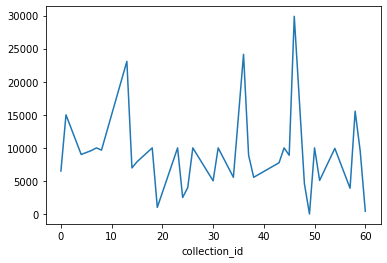

In [25]:
df_all_train.groupby('collection_id')['collection_id'].count().plot()

In [26]:
def plot_corr(df, describe, figsize=(4,4)):
  plt.figure(figsize =figsize)
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype = bool))
  sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6)
  title=f'Correlation of {describe} Variables'
  plt.title(title)
  plt.show()


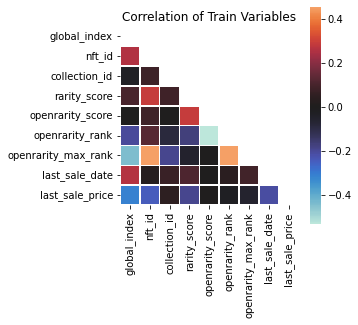

In [27]:
plot_corr(df_all_train,'Train')

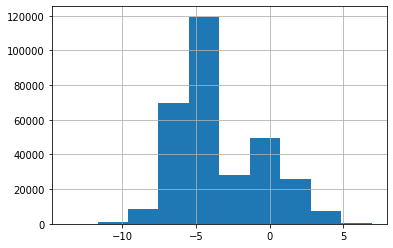

In [28]:
df_all_train.last_sale_price.hist()

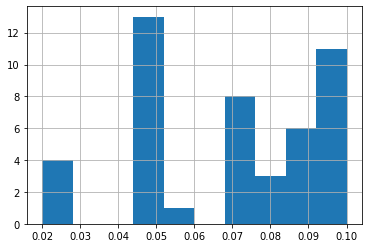

In [29]:
df_cols.seller_fees.hist()

In [30]:
df_all_train[df_all_train.collection_id.isin([49,0,38,37,59,19,26])].describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,41453.000000,41453.000000,41453.000000,41453.000000,14443.000000,14443.00000,14443.000000,41453.000000,41453.000000
mean,293070.699009,4142.983403,33.289919,140.056423,1.000000,3801.52586,7582.076923,202199.045521,-3.517806
std,170076.589033,2650.743844,18.684191,233.573074,0.132693,2384.36402,1602.600498,26.797274,2.637434
min,21928.000000,0.000000,0.000000,1.000000,0.770374,1.00000,5555.000000,202104.000000,-13.696744
25%,175071.000000,1872.000000,26.000000,52.442926,0.931205,1804.50000,5555.000000,202205.000000,-5.392924
50%,215432.000000,3945.000000,37.000000,108.716551,0.990835,3611.00000,8849.000000,202207.000000,-4.706452
75%,322712.000000,6133.000000,38.000000,161.446023,1.050099,5416.50000,8849.000000,202209.000000,-1.047253
max,562664.000000,9999.000000,59.000000,9793.201352,3.663833,8849.00000,8849.000000,202211.000000,6.024644


In [31]:
df_all_train[~df_all_train.collection_id.isin([49,0,38,37,59,19,26])].describe()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
count,268457.000000,268457.000000,268457.000000,268457.000000,66037.000000,66037.000000,66037.000000,268457.000000,268457.000000
mean,320698.676097,7138.888917,30.077469,1637.370556,1.000000,6030.107667,12059.318791,202191.375155,-3.596685
std,173312.800242,6242.022048,18.238862,4590.468484,0.156885,3946.652814,3220.157346,35.358747,2.976302
min,32621.000000,0.000000,1.000000,6.086957,0.626738,1.000000,5555.000000,202103.000000,-13.752673
25%,126682.000000,2567.000000,13.000000,115.935029,0.904555,2752.000000,9999.000000,202202.000000,-5.517734
50%,360470.000000,5436.000000,34.000000,179.105017,0.973403,5504.000000,10000.000000,202206.000000,-4.831250
75%,493990.000000,9269.000000,46.000000,319.059293,1.062781,8795.000000,15000.000000,202209.000000,-1.161178
max,590227.000000,29898.000000,60.000000,90354.072248,3.162588,15555.000000,15555.000000,202211.000000,6.931473


# Create CV test for training 

In [32]:
gs = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=MY_SEED)
train_ix, valid_ix = next(gs.split(df_all_train, groups=df_all_train.collection_id))

In [33]:
df_train_raw=df_all_train.loc[train_ix,]


In [34]:
df_valid_raw=df_all_train.loc[valid_ix,]

## Feature Engineering

In [35]:
from sklearn.base import TransformerMixin, BaseEstimator

class CategoricalTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.labelEncoder_vs=LabelEncoder() # verification_status_encoded
        self.labelEncoder_ct=LabelEncoder() # contract_type

    def fit(self, df, y=None):            
        self.labelEncoder_vs.fit(df['verification_status'])
        self.labelEncoder_ct.fit(df['contract_type'])
        return self    

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting categorical feature with input shape: {df.shape}')
        df['verification_status']=self.labelEncoder_vs.transform(df.verification_status).astype("int")
        df['contract_type']=self.labelEncoder_ct.transform(df.contract_type).astype("int")
        df['openrarity_enabled']=df['openrarity_enabled'].astype("int")
        df['has_website']=df['has_website'].astype("int")
        df['has_own_twitter']=df['has_own_twitter'].astype("int")
        df['has_discord']=df['has_discord'].astype("int")
        df['has_medium']=df['has_medium'].astype("int")

        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names


In [36]:
class FeatureTransformers(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, df, y=None):    
        self.avg_avg_likes=df['avg_likes'].mean()                
        self.avg_avg_replies=df['avg_replies'].mean()                
        self.avg_avg_retweets=df['avg_retweets'].mean()                
        self.avg_fee=(df['seller_fees']+df['platform_fees']).mean()
        return self    

    def transform(self, df, y=None):
        self.feature_names=['shelf_duration','openrarity_ratio','last_sale_date_year','last_sale_date_month',
                            'inverse_total_supply','ratio_avg_likes','ratio_avg_replies','ratio_avg_retweets',
                            'total_avg_likes','total_avg_twitter_activity', 'total_fee','ratio_avg_fee']            
        self.feature_names.extend(df.columns.values)     
        
        print(f'starting feature with input shape: {df.shape}')
        df['last_sale_date_year']=df['last_sale_date']//100
        df['last_sale_date_month']=df['last_sale_date']%100
        df['shelf_duration']=df['last_sale_date']-df['creation_date']
        df['openrarity_ratio']=df['openrarity_rank']/df['openrarity_max_rank']      
        df['inverse_total_supply']=1/df['total_supply']
        df['ratio_avg_likes']=df['avg_likes']/self.avg_avg_likes
        df['ratio_avg_replies']=df['avg_replies']/self.avg_avg_replies
        df['ratio_avg_retweets']=df['avg_retweets']/self.avg_avg_retweets
        df['total_avg_likes']=df['avg_retweets']*df['n_tweets_in_range']
        df['total_avg_twitter_activity']=df['avg_likes']+df['avg_retweets']+df['avg_replies']
        df['total_fee']=df['seller_fees']+df['platform_fees']
        df['ratio_avg_fee']=df['total_fee']/self.avg_fee

        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [37]:
class AvgPriceTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, df, y=None):   


        self.last_sale_year_avg_price=df.groupby('last_sale_date_year')['last_sale_price'].mean().rename('last_sale_price_year_avg')
        self.last_sale_year_std_price=df.groupby('last_sale_date_year')['last_sale_price'].std().rename('last_sale_price_year_std')
        self.last_sale_year_min_price=df.groupby('last_sale_date_year')['last_sale_price'].min().rename('last_sale_price_year_min')
        self.last_sale_year_max_price=df.groupby('last_sale_date_year')['last_sale_price'].max().rename('last_sale_price_year_max')

        self.last_sale_month_avg_price=df.groupby('last_sale_date_month')['last_sale_price'].mean().rename('last_sale_price_month_avg')
        self.last_sale_month_std_price=df.groupby('last_sale_date_month')['last_sale_price'].std().rename('last_sale_price_month_std')

        self.shelf_life_avg_price=df.groupby('shelf_duration')['last_sale_price'].mean().rename('last_sale_price_shelf_life_avg')
        self.shelf_life_std_price=df.groupby('shelf_duration')['last_sale_price'].std().rename('last_sale_price_shelf_life_std')
        self.shelf_life_min_price=df.groupby('shelf_duration')['last_sale_price'].min().rename('last_sale_price_shelf_life_min')
        self.shelf_life_max_price=df.groupby('shelf_duration')['last_sale_price'].max().rename('last_sale_price_shelf_life_max')

        self.last_sale_year_month_avg_price=df.groupby('last_sale_date')['last_sale_price'].mean().rename('last_sale_price_avg')
        self.last_sale_year_month_std_price=df.groupby('last_sale_date')['last_sale_price'].std().rename('last_sale_price_std')
        self.last_sale_year_month_min_price=df.groupby('last_sale_date')['last_sale_price'].min().rename('last_sale_price_min')
        self.last_sale_year_month_max_price=df.groupby('last_sale_date')['last_sale_price'].max().rename('last_sale_price_max')

        return self    

    def transform(self, df, y=None):
        self.feature_names=['last_sale_price_shelf_life_avg','last_sale_price_shelf_life_std','last_sale_price_shelf_life_min','last_sale_price_shelf_life_max',
                            'last_sale_price_year_avg', 'last_sale_price_year_std','last_sale_price_year_min','last_sale_price_year_max',
                            'last_sale_price_month_avg','last_sale_price_month_std', 'last_sale_price_avg', 'last_sale_price_std', 'last_sale_price_min','last_sale_price_max']            

        self.feature_names.extend(df.columns.values)     

        print(f'starting avg price feature with input shape: {df.shape}')
        
        df=df.merge(self.last_sale_year_month_avg_price,on='last_sale_date', how='left')
        df=df.merge(self.last_sale_year_month_std_price,on='last_sale_date', how='left')
        df=df.merge(self.last_sale_year_month_min_price,on='last_sale_date', how='left')
        df=df.merge(self.last_sale_year_month_max_price,on='last_sale_date', how='left')
        
        df=df.merge(self.last_sale_year_avg_price,on='last_sale_date_year', how='left')
        df=df.merge(self.last_sale_year_std_price,on='last_sale_date_year', how='left')
        df=df.merge(self.last_sale_year_min_price,on='last_sale_date_year', how='left')
        df=df.merge(self.last_sale_year_max_price,on='last_sale_date_year', how='left')

        df=df.merge(self.last_sale_month_avg_price,on='last_sale_date_month', how='left')
        df=df.merge(self.last_sale_month_std_price,on='last_sale_date_month', how='left')

        df=df.merge(self.shelf_life_avg_price,on='shelf_duration', how='left')
        df=df.merge(self.shelf_life_std_price,on='shelf_duration', how='left')
        df=df.merge(self.shelf_life_min_price,on='shelf_duration', how='left')
        df=df.merge(self.shelf_life_max_price,on='shelf_duration', how='left')
      
        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [38]:
class FillNAImputer(TransformerMixin, BaseEstimator):        
        
    def fit(self, x, y=None):    
        return self   

    def transform(self, df, y=None):
        self.feature_names=[]    
        self.feature_names.extend(df.columns.values)     
                                    
        print(f'starting fill na imputer with input shape:  {df.shape}')                        
        # first fill zero values with NA 
        df.fillna(0,inplace=True)
        return  df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names    

In [39]:
def createPreprocessing():
    preprocessing=make_pipeline(CategoricalTransformer(),                             
                                FeatureTransformers(),
                                AvgPriceTransformer(),
                                FillNAImputer(),
                                verbose=True)
    return preprocessing
preprocessing=createPreprocessing()
preprocessing_all=createPreprocessing()

In [40]:
num_features=['total_avg_twitter_activity','total_avg_likes','ratio_avg_likes','ratio_avg_replies','ratio_avg_retweets','inverse_total_supply', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'total_supply','n_of_traits', 
              'n_tweets_in_range', 'avg_likes', 'avg_replies', 'avg_retweets', 'min_likes', 'min_replies', 'min_retweets', 'max_likes', 'max_replies','max_retweets',
              'shelf_duration','openrarity_ratio','last_sale_date_year','last_sale_date_month',
              'last_sale_price_shelf_life_avg','last_sale_price_shelf_life_std','last_sale_price_shelf_life_min','last_sale_price_shelf_life_max',
              'last_sale_price_year_avg', 'last_sale_price_year_std','last_sale_price_year_min','last_sale_price_year_max',
              'last_sale_price_avg', 'last_sale_price_std', 'last_sale_price_min','last_sale_price_max']

"""
num_features=['total_avg_likes',  'n_of_traits', 'total_supply',
       'shelf_duration', 'avg_likes', 'max_replies', 'avg_replies', 'ratio_avg_likes',
       'max_likes', 'total_avg_twitter_activity', 'last_sale_price_std',
       'max_retweets', 'last_sale_date_month', 'ratio_avg_replies',
       'rarity_score', 'ratio_avg_retweets', 'avg_retweets',
       'last_sale_price_avg', 'last_sale_price_month_avg','last_sale_price_month_std',
       'last_sale_price_shelf_life_max', 'last_sale_price_max',
       'n_tweets_in_range', 'last_sale_price_min', 'min_retweets',
       'last_sale_price_shelf_life_avg']
"""
cat_features=['contract_type','creation_date', 'last_sale_date'] #['verification_status','contract_type','openrarity_enabled', 'has_website','has_own_twitter', 'has_discord', 'has_medium','creation_date','last_sale_date']
target_feature='last_sale_price'
#target_feature='total_sale_price'
all_column_names= num_features + cat_features

In [41]:
df_train=df_train_raw.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_processed=preprocessing.fit_transform(df_train.copy())
df_train_label=df_train_processed[target_feature].copy()
df_train_processed.drop([target_feature,'Unnamed: 0_x'],axis=1,inplace=True)
df_train_processed.describe(include='all')

starting categorical feature with input shape: (270911, 33)
[Pipeline]  (step 1 of 4) Processing categoricaltransformer, total=   0.1s
starting feature with input shape: (270911, 33)
[Pipeline]  (step 2 of 4) Processing featuretransformers, total=   0.1s
starting avg price feature with input shape: (270911, 45)
[Pipeline]  (step 3 of 4) Processing avgpricetransformer, total=   1.2s
starting fill na imputer with input shape:  (270911, 59)
[Pipeline] ..... (step 4 of 4) Processing fillnaimputer, total=   0.0s


,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_month_avg,last_sale_price_month_std,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,inverse_total_supply,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,total_avg_likes,total_avg_twitter_activity,total_fee,ratio_avg_fee,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
count,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,2.709110e+05,270911.000000,270911.0,270911.0,270911.00000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000,270911.000000
mean,-3.657076,2.496576,-13.018833,4.634094,-3.657076,2.795348,-13.718751,5.996173,-3.657076,2.696203,-3.657076,2.592079,-13.202979,4.658428,41.242142,0.130153,2021.858171,7.131139,0.000111,1.000000,1.000000,1.000000,541.011771,143.767150,0.082055,0.879322,313011.868983,7005.080237,31.997682,1613.169411,0.260163,1488.019250,2974.737722,202192.948252,13925.269269,202151.706110,0.625187,10.889192,0.552591,0.060072,2.500000e-02,0.260163,0.0,1.0,0.73832,0.114831,24.762627,17.260739,82.886508,20.912914,39.967727,10.127307,2.258052,5.013499,335.764834,120.056347,194.241072
std,1.200762,0.521183,0.686200,1.232245,0.358559,0.056038,0.083443,0.011574,0.741311,0.356240,1.015217,0.443455,0.542566,0.950761,46.770084,0.264333,0.348875,3.122525,0.001925,1.943164,3.145946,2.167695,1257.661744,296.261781,0.038691,0.414622,169789.962619,6257.409496,17.851230,4568.883455,0.446006,3207.724628,5351.582374,33.822928,8334.964228,47.757439,0.484076,5.115975,0.497227,0.032683,1.387781e-17,0.438724,0.0,0.0,0.43955,0.318819,13.843448,28.677184,161.062093,65.790897,86.637841,29.494869,8.211830,9.227290,955.556053,474.914520,555.325729
min,-6.108004,0.000000,-13.752673,-4.823387,-3.802841,2.772567,-13.752673,5.991468,-4.738821,2.194067,-5.005503,1.895498,-13.752673,-2.223663,-8.000000,0.000000,2021.000000,1.000000,0.000033,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,21928.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,202103.000000,1.000000,202102.000000,0.000000,1.000000,0.000000,0.000000,2.500000e-02,0.000000,0.0,1.0,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.993846,1.937194,-13.471287,4.276676,-3.802841,2.772567,-13.752673,5.991468,-4.190512,2.455766,-4.565791,2.219259,-13.565684,3.761349,1.000000,0.000000,2022.000000,4.000000,0.000043,0.024129,0.009563,0.025020,2.000000,13.055556,0.075000,0.803717,175142.500000,2455.000000,14.000000,102.573258,0.000000,0.000000,0.000000,202202.000000,8888.000000,202108.000000,0.000000,8.000000,0.000000,0.050000,2.500000e-02,0.000000,0.0,1.0,0.00000,0.000000,11.000000,3.000000,2.000000,0.200000,1.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000
50

In [42]:
pd.isnull(df_train_processed).sum(axis=0)

last_sale_price_shelf_life_avg    0
last_sale_price_shelf_life_std    0
last_sale_price_shelf_life_min    0
last_sale_price_shelf_life_max    0
last_sale_price_year_avg          0
last_sale_price_year_std          0
last_sale_price_year_min          0
last_sale_price_year_max          0
last_sale_price_month_avg         0
last_sale_price_month_std         0
last_sale_price_avg               0
last_sale_price_std               0
last_sale_price_min               0
last_sale_price_max               0
shelf_duration                    0
openrarity_ratio                  0
last_sale_date_year               0
last_sale_date_month              0
inverse_total_supply              0
ratio_avg_likes                   0
ratio_avg_replies                 0
ratio_avg_retweets                0
total_avg_likes                   0
total_avg_twitter_activity        0
total_fee                         0
ratio_avg_fee                     0
global_index                      0
nft_id                      

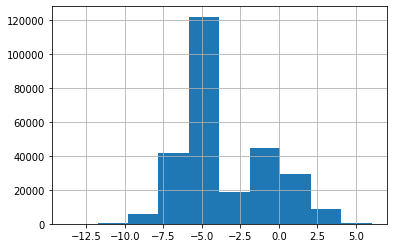

In [43]:
df_train_label.hist()

In [44]:
df_valid=df_valid_raw.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_valid_processed=preprocessing.transform(df_valid)
df_valid_label=df_valid_processed[target_feature].copy()
df_valid_processed.drop([target_feature,'Unnamed: 0_x'],axis=1,inplace=True)
df_valid_processed

starting categorical feature with input shape: (38999, 33)
starting feature with input shape: (38999, 33)
starting avg price feature with input shape: (38999, 45)
starting fill na imputer with input shape:  (38999, 59)


,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_month_avg,last_sale_price_month_std,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,inverse_total_supply,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,total_avg_likes,total_avg_twitter_activity,total_fee,ratio_avg_fee,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-3.259461,3.085732,-1.586169,2.462232,-5.696157,0.521607,1,0.0,2021,5,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116861,0,7,204.010980,0.0,0.0,0.0,202105,9998,202104,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
1,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-3.259461,3.085732,-1.586169,2.462232,-5.696157,0.521607,1,0.0,2021,5,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116862,1,7,182.480289,0.0,0.0,0.0,202105,9998,202104,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
2,-4.993846,1.904839,-13.696744,4.653998,-2.775084,2.933191,-13.513497,6.024644,-4.190512,2.455766,-2.918139,2.553923,-11.883655,4.653998,7,0.0,2021,11,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116863,2,7,221.312185,0.0,0.0,0.0,202111,9998,202104,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
3,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-3.259461,3.085732,-1.586169,2.462232,-5.696157,0.521607,1,0.0,2021,5,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116864,3,7,149.498840,0.0,0.0,0.0,202105,9998,202104,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
4,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-3.259461,3.085732,-1.586169,2.462232,-5.696157,0.521607,1,0.0,2021,5,0.000100,0.000000,0.0000,2.798091,1342.0,111.833333,0.050,0.535811,116865,4,7,268.527043,0.0,0.0,0.0,202105,9998,202104,1,7,1,0.025,0.025,0,0,1,1,0,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-3.711280,2.762806,-4.298561,2.398092,-13.696744,5.991468,6,0.0,2022,8,0.000111,0.098374,0.0423,0.028869,30.0,10.192308,0.115,1.232366,590223,8995,4,128.268841,0.0,0.0,0.0,202208,9000,202202,0,8,0,0.090,0.025,0,0,1,0,0,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
38995,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-3.711280,2.762806,-4.298561,2.398092,-13.696744,5.991468,6,0.0,2022,8,0.000111,0.098374,0.0423,0.028869,30.0,10.192308,0.115,1.232366,590224,8996,4,152.040769,0.0,0.0,0.0,202208,9000,202202,0,8,0,0.090,0.025,0,0,1,0,0,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12
38996,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-3.711280,2.762806,-4.298561,2.398092,-13.696744,5.991468,6,0.0,2022,8,0.000111,0.098374,0.0423,0.028869,30.0,10.192308,0.115,1.232366,590225,8997,4,178.734807,0.0,0.0,0.0,202208,9000,202202,0,8,0,0.090,0.025,0,0,1,0,0,4,26,8.153846,0.884615,1.153846,0,0,0,3

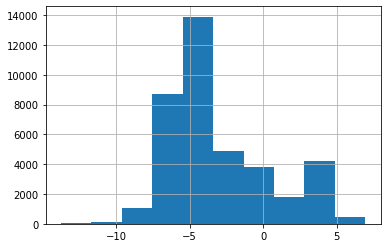

In [45]:
df_valid_label.hist()

In [46]:
df_train_all_merged=df_all_train.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_all_merged_label=df_train_all_merged[target_feature].copy()
#df_train_all_merged.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)

In [47]:
df_test_all_merged=df_nfts_predict.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_test_all_merged
#df_test_all_merged_label=df_test_all_merged[target_feature].copy()
#df_train_all_merged.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,Unnamed: 0_x,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium,Unnamed: 0_y,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,0,0,29,176.364208,NaN,NaN,NaN,202206,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
1,1,1,29,207.209228,NaN,NaN,NaN,202205,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
2,2,2,29,157.293414,NaN,NaN,NaN,202210,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
3,3,3,29,173.372185,NaN,NaN,NaN,202206,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
4,4,4,29,190.077584,NaN,NaN,NaN,202206,9,9999,202205,verified,10,own,0.075,0.025,False,False,True,False,False,22,2,340.500000,68.500000,109.000000,0,0,11,681,137,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181209,618137,7140,42,134.963415,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13
181210,618138,7141,42,128.686047,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13
181211,618139,7142,42,22134.000000,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13
181212,618140,7143,42,22134.000000,NaN,NaN,NaN,202104,29,22134,202101,approved,80,default,0.070,0.025,False,False,True,True,True,32,668,1.252994,0.302395,0.314371,0,0,0,80,6,13


In [48]:
df_train_all_processed=df_all_train.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_train_all_processed_label=df_train_all_processed[target_feature].copy()
#df_train_all_processed.drop(['last_sale_price','Unnamed: 0_x'],axis=1,inplace=True)
#df_train_all_processed=preprocessing_all.fit_transform(df_train_all_processed.copy())
#df_train_all_processed

In [49]:
df_valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38999 entries, 0 to 38998
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   last_sale_price_shelf_life_avg  38999 non-null  float64
 1   last_sale_price_shelf_life_std  38999 non-null  float64
 2   last_sale_price_shelf_life_min  38999 non-null  float64
 3   last_sale_price_shelf_life_max  38999 non-null  float64
 4   last_sale_price_year_avg        38999 non-null  float64
 5   last_sale_price_year_std        38999 non-null  float64
 6   last_sale_price_year_min        38999 non-null  float64
 7   last_sale_price_year_max        38999 non-null  float64
 8   last_sale_price_month_avg       38999 non-null  float64
 9   last_sale_price_month_std       38999 non-null  float64
 10  last_sale_price_avg             38999 non-null  float64
 11  last_sale_price_std             38999 non-null  float64
 12  last_sale_price_min             

In [50]:
df_valid_processed[all_column_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38999 entries, 0 to 38998
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   total_avg_twitter_activity      38999 non-null  float64
 1   total_avg_likes                 38999 non-null  float64
 2   ratio_avg_likes                 38999 non-null  float64
 3   ratio_avg_replies               38999 non-null  float64
 4   ratio_avg_retweets              38999 non-null  float64
 5   inverse_total_supply            38999 non-null  float64
 6   rarity_score                    38999 non-null  float64
 7   openrarity_score                38999 non-null  float64
 8   openrarity_rank                 38999 non-null  float64
 9   openrarity_max_rank             38999 non-null  float64
 10  total_supply                    38999 non-null  int64  
 11  n_of_traits                     38999 non-null  int64  
 12  n_tweets_in_range               

In [51]:
df_train_processed[all_column_names]

,total_avg_twitter_activity,total_avg_likes,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,inverse_total_supply,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,n_of_traits,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,contract_type,creation_date,last_sale_date
0,257.193548,1889.0,2.267772,0.396421,1.524617,1.000000,2.000000,0.0,0.0,0.0,1,2,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,7,0.0,2022,11,-4.993846,1.904839,-13.696744,4.653998,-3.802841,2.772567,-13.752673,5.991468,-4.700451,2.219259,-13.752673,3.761349,1,202204,202211
1,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,97.077216,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,0.0,2021,8,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-0.559392,2.439283,-12.663575,4.867574,1,202107,202108
2,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,139.453086,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,101,0.0,2022,8,-4.669584,2.511041,-12.903621,5.991468,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,1,202107,202208
3,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,127.753445,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1,0.0,2021,8,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-0.559392,2.439283,-12.663575,4.867574,1,202107,202108
4,201.818182,607.0,1.606797,0.643361,1.380659,0.000113,112.315719,0.0,0.0,0.0,8888,5,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,102,0.0,2022,9,-5.282691,1.715966,-13.752673,3.496722,-3.802841,2.772567,-13.752673,5.991468,-4.565791,2.176448,-13.565684,3.238770,1,202107,202209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270906,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,401.063769,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,2022,8,-4.993846,1.904839,-13.696744,4.653998,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202201,202208
270907,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,148.726179,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,2022,8,-4.993846,1.904839,-13.696744,4.653998,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202201,202208
270908,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,196.309829,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,2022,8,-4.993846,1.904839,-13.696744,4.653998,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202201,202208
270909,14.775000,130.0,0.097422,0.164970,0.081316,0.000100,117.435698,0.0,0.0,0.0,10000,9,40,8.075000,3.450000,3.250000,0,0,0,91,96,88,7,0.0,2022,8,-4.993846,1.904839,-13.696744,4.653998,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202201,202208


In [52]:
df_valid_processed[all_column_names]

,total_avg_twitter_activity,total_avg_likes,ratio_avg_likes,ratio_avg_replies,ratio_avg_retweets,inverse_total_supply,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,total_supply,n_of_traits,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,shelf_duration,openrarity_ratio,last_sale_date_year,last_sale_date_month,last_sale_price_shelf_life_avg,last_sale_price_shelf_life_std,last_sale_price_shelf_life_min,last_sale_price_shelf_life_max,last_sale_price_year_avg,last_sale_price_year_std,last_sale_price_year_min,last_sale_price_year_max,last_sale_price_avg,last_sale_price_std,last_sale_price_min,last_sale_price_max,contract_type,creation_date,last_sale_date
0,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,204.010980,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,2021,5,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-1.586169,2.462232,-5.696157,0.521607,1,202104,202105
1,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,182.480289,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,2021,5,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-1.586169,2.462232,-5.696157,0.521607,1,202104,202105
2,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,221.312185,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,7,0.0,2021,11,-4.993846,1.904839,-13.696744,4.653998,-2.775084,2.933191,-13.513497,6.024644,-2.918139,2.553923,-11.883655,4.653998,1,202104,202111
3,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,149.498840,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,2021,5,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-1.586169,2.462232,-5.696157,0.521607,1,202104,202105
4,111.833333,1342.0,0.000000,0.0000,2.798091,0.000100,268.527043,0.0,0.0,0.0,9998,7,12,0.000000,0.000000,111.833333,0,0,31,0,0,463,1,0.0,2021,5,-2.606563,2.807101,-12.438617,4.867574,-2.775084,2.933191,-13.513497,6.024644,-1.586169,2.462232,-5.696157,0.521607,1,202104,202105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,128.268841,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,2022,8,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202202,202208
38995,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,152.040769,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,2022,8,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202202,202208
38996,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,178.734807,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,2022,8,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202202,202208
38997,10.192308,30.0,0.098374,0.0423,0.028869,0.000111,130.974464,0.0,0.0,0.0,9000,8,26,8.153846,0.884615,1.153846,0,0,0,30,6,12,6,0.0,2022,8,-4.821487,2.182397,-12.585259,6.024644,-3.802841,2.772567,-13.752673,5.991468,-4.298561,2.398092,-13.696744,5.991468,0,202202,202208


In [53]:
df_train_processed[all_column_names].apply(lambda x: x.unique())

total_avg_twitter_activity        [257.19354838709677, 201.81818181818184, 8.947...
total_avg_likes                   [1889.0, 607.0, 170.0, 2399.0, 82.0, 16.0, 24....
ratio_avg_likes                   [2.2677724848600023, 1.6067973134455125, 0.0, ...
ratio_avg_replies                 [0.39642119820245936, 0.6433606145570866, 0.0,...
ratio_avg_retweets                [1.5246171847329024, 1.380659394827423, 0.2238...
inverse_total_supply              [1.0, 0.0001125112511251125, 0.000100030009002...
rarity_score                      [2.0, 97.07721623225166, 139.45308602172497, 1...
openrarity_score                  [0.0, 0.986535021319271, 1.003833199964582, 0....
openrarity_rank                   [0.0, 5814.0, 4386.0, 6549.0, 3497.0, 4926.0, ...
openrarity_max_rank               [0.0, 9928.0, 15555.0, 5555.0, 8849.0, 15000.0...
total_supply                      [1, 8888, 9997, 5022, 6501, 12505, 7993, 9998,...
n_of_traits                       [2, 5, 19, 8, 31, 6, 10, 14, 13, 12, 1, 4,

In [54]:
df_train_label.describe()

count    270911.000000
mean         -3.657076
std           2.818802
min         -13.752673
25%          -5.503014
50%          -4.817793
75%          -1.089536
max           6.024644
Name: last_sale_price, dtype: float64

In [55]:
df_valid_label.describe()

count    38999.000000
mean        -3.093331
std          3.592321
min        -13.751520
25%         -5.494596
50%         -4.798053
75%         -1.286333
max          6.931473
Name: last_sale_price, dtype: float64

In [56]:
df_valid_processed[all_column_names].apply(lambda x: x.unique())

total_avg_twitter_activity        [111.83333333333331, 391.66666666666663, 10.19...
total_avg_likes                     [1341.9999999999998, 309.0, 29.999999999999993]
ratio_avg_likes                       [0.0, 2.742706130937027, 0.09837362391585547]
ratio_avg_replies                   [0.0, 2.9327970357287008, 0.042299957246087025]
ratio_avg_retweets                [2.7980908822683164, 2.5770792328492096, 0.028...
inverse_total_supply              [0.00010002000400080016, 0.0001000100010001000...
rarity_score                      [204.0109803902137, 182.48028907683928, 221.31...
openrarity_score                  [0.0, 0.845854681585512, 0.922150504780118, 1....
openrarity_rank                   [0.0, 9532.0, 6731.0, 2395.0, 2525.0, 217.0, 8...
openrarity_max_rank                                                   [0.0, 9999.0]
total_supply                                              [9998, 9999, 10000, 9000]
n_of_traits                                                              [7,

In [57]:
df_train_label

0         0.236441
1         0.182620
2         1.157061
3         1.253594
4         1.388683
            ...   
270906   -5.167134
270907   -5.455711
270908   -5.600740
270909   -4.835459
270910   -7.218881
Name: last_sale_price, Length: 270911, dtype: float64

# Model Training with LightGBM and DART

In [58]:
class ExpRMSEMetric(tf.keras.metrics.Metric):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.mse=tf.keras.metrics.MeanSquaredError()

  def reset_state(self):
    self.mse.reset_state()    

  def update_state(self,y_true, y_pred, sample_weight=None):
    self.mse.update_state(inv_my_norm(y_true),inv_my_norm(y_pred))    
  
  def result(self):
    mean_squared_error=self.mse.result()
    rmse=tf.sqrt(mean_squared_error)
    res=tf.exp(-rmse/10)
    return res


In [59]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredError

def create_exp_rmse_score(mult=-1, log=False):
  def exp_rmse_score_fn(y_true, y_hat):    
      mse=MeanSquaredError()
      mse_res=mse(y_true,y_hat)
      rmse=K.sqrt(mse_res)
      res=K.exp(mult*rmse/10)
      if log:
        print(f"Tensor mse_res:{mse_res} rmse: {rmse} res: {res} mult:{mult}")
      return res
  return exp_rmse_score_fn

def lgb_exp_rmse_score(y_true, y_hat):        

    res=exp_rmse_score(y_true,y_hat)
    #print(f"res: {res}")
    return 'exp_rmse', res, True

def exp_rmse_score(y_true, y_hat):            
    rmse=mean_squared_error (inv_my_norm(y_true,is_tf=False), inv_my_norm(y_hat, is_tf=False), squared=False)        
    res=np.exp(-rmse/10)

    print(f"Numpy rmse: {rmse} res: {res}")

    return res

In [60]:
a=np.random.rand(20)
b=a*0.1

In [61]:
K.exp(-1*9.6/10)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3828929>

In [62]:
tensor_exp_rmse_score=create_exp_rmse_score(-1)
tensor_exp_rmse_score(a,b)

<tf.Tensor: shape=(), dtype=float64, numpy=0.946328668017229>

In [63]:
def create_catboost_regressor(num_iter=1000):    
    params = {
        'iterations':num_iter, 
        'objective':'RMSE',
        #'objective':'Huber',        
        'max_depth':6, 
        'learning_rate':0.01, 
        'loss_function':'RMSE',
        'min_data_in_leaf':120,
        'early_stopping_rounds':50,
        #'eval_metric':exp_rmse_score,
        #'score_function':[exp_rmse_score],
        'verbose':1
    } 
    
    #lgb_valid = [(df_train_processed[all_column_names],df_train_label),
    #            (df_valid_processed[all_column_names],df_valid_label)]
    #'eval_set':lgb_valid,                
    fit_params={#'feature_name':all_column_names,
                'cat_features':cat_features,                
                'verbose':1
               }
    model= CatBoostRegressor(**params)    
    return model, fit_params

In [64]:
def create_lgb_regressor(num_iter=1000):    
    params = {
        'force_col_wise':True, # memory foot print is smaller
        'n_estimators':num_iter,
        'objective': 'regression',
        'metric': "rmse",
        #'metric':[lgb_exp_rmse_score],
        #'boosting_type': 'dart',
        'max_depth' : -1,
        'random_state': MY_SEED,        
        'learning_rate': 0.01,
        #'num_leaves': 2 ** 6, 
        'min_data_in_leaf': 50,
        #'subsample': 0.8,  
        #'subsample_freq': 1,
        #'first_metric_only': True,
        #'boost_from_average': False,
        #'tree_learner': 'serial',        
        'verbose': 2,      
    }   

    fit_params={'feature_name':all_column_names,
                'eval_metric':[lgb_exp_rmse_score],
                'categorical_feature':cat_features,
                'verbose':2
               }

    model=lgb.LGBMRegressor(**fit_params)
    return model, fit_params

In [67]:
import tensorflow as tf
def create_mlp_regressor(lr0=0.001,num_iter=1000):  

  tf.random.set_seed(MY_SEED)
  norm_layer= tf.keras.layers.Normalization(input_shape=(len(all_column_names),))
  #regulazier=tf.keras.regularizers.L1L2(0.01,0.01)
  regulazier=tf.keras.regularizers.L2(0)
  model= tf.keras.Sequential([
      norm_layer,
      tf.keras.layers.Dense(300,activation='relu'),      
      tf.keras.layers.Dense(300,activation='relu'),      
      tf.keras.layers.Dense(200,activation='relu'),
      #tf.keras.layers.Dense(32,activation='swish', kernel_initializer='he_normal', kernel_regularizer=regulazier),
      ##tf.keras.layers.Dropout(0.15),      
      #tf.keras.layers.Dense(32,activation='swish', kernel_initializer='he_normal', kernel_regularizer=regulazier),
      ##tf.keras.layers.Dropout(0.15),
      ##tf.keras.layers.Dense(1, activation='relu', kernel_initializer='he_normal')
      tf.keras.layers.Dense(1 ) # activation='exponential'
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr0)  
  #optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)  
  #optimizer = tf.keras.optimizers.SGD(learning_rate=lr0,nesterov=True)
  #loss=tf.keras.losses.Huber(delta=1.35)
  #loss=tf.keras.losses.MeanSquaredLogarithmicError()    
  #loss=tf.keras.losses.LogCosh()
  #loss= tf.keras.losses.MeanAbsolutePercentageError()
  loss='mse'
  #loss=create_exp_rmse_score(1)
  model.compile(loss=loss, optimizer=optimizer, metrics= [tf.keras.metrics.RootMeanSquaredError(), ExpRMSEMetric() ])
  #model.compile(loss="mse", optimizer=optimizer, metrics= [exp_rmse_score])
  exp_rmse_score

  fit_params={
      'epochs':num_iter
  }

  return model, fit_params, norm_layer


In [ ]:
from sklearn.model_selection import KFold
# CV 
def apply_cross_validation(lr0=0.001,num_iter=100,cv=5):    
    seed_everything()        
    col_ids=df_train_all_merged.collection_id.unique()
    print(f"col_ids: {col_ids}")
    pred_results=np.zeros(len(df_train_all_merged))
    y_true=np.zeros(len(df_train_all_merged))
    fold_results=[]

    res=None
    kf = KFold(n_splits=cv, shuffle=True, random_state=MY_SEED)   
    for i, (train_index, test_index) in enumerate(kf.split(df_train_all_merged)):            
      print(f"MAX_SALE: {MAX_SALE}")
      df_train_processed=df_train_all_merged.iloc[train_index].copy()     
      df_valid_processed=df_train_all_merged.iloc[test_index].copy()
      df_train_processed_label=df_train_all_merged_label.iloc[train_index]
      df_valid_processed_label=df_train_all_merged_label.iloc[test_index]

      preprocessing=createPreprocessing()
      df_train_processed=preprocessing.fit_transform(df_train_processed)
      df_valid_processed=preprocessing.transform(df_valid_processed)

      regressor, fit_params, norm_layer=create_mlp_regressor(lr0,num_iter)
      if i==0:        
        print(regressor.summary())

      lgb_valid = [(df_train_processed[all_column_names].values,df_train_processed_label.values),
                  (df_valid_processed[all_column_names].values,df_valid_processed_label.values)]
      #fit_params['regressior__eval_set']=lgb_valid   
      fit_params['validation_data']=(df_valid_processed[all_column_names].values,df_valid_processed_label.values)   
      lr_scdeduler=tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
     
      def exponential_decay(lr0=0.01, s=5):
        def exponential_decay_fn(epoch):
          if (epoch % 10 <1):
            return lr0*2
          #return lr0*0.1**(epoch/s)
          return lr0
        return exponential_decay_fn
      
      exponential_decay_fn =exponential_decay(lr0=lr0, s=10)

      #lr_scdeduler=tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
      early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor="val_root_mean_squared_error", patience=50, restore_best_weights=True)

      batch_size=df_train_processed.shape[0]
      norm_layer.adapt(df_train_processed[all_column_names].to_numpy())
      history=regressor.fit(df_train_processed[all_column_names].to_numpy(), df_train_processed_label.to_numpy(),  **fit_params, callbacks=[early_stopping_cb, lr_scdeduler], batch_size=batch_size)  
      #mse, rmse=regressor.evaluate(df_valid_processed[all_column_names].values,df_valid_processed_label.values)
      #fold_results.append(np.exp(-rmse*MAX_SALE/10))
      eval_results=regressor.evaluate(df_valid_processed[all_column_names].to_numpy(),df_valid_processed_label.to_numpy())
      fold_results.append(eval_results)
      predict_hat=regressor.predict(df_valid_processed[all_column_names].to_numpy())
      print(f" predict_hat shape: {predict_hat.shape}")
      predict_hat=predict_hat[:,0]*MAX_SALE
      pred_results[test_index]=predict_hat*MAX_SALE
      y_true[test_index]=df_valid_processed_label*MAX_SALE

      scr=exp_rmse_score(df_valid_processed_label,predict_hat)     

      print(f" fold: {i} exp_rmse_score: {scr}  eval_results: {eval_results} fold_results: {fold_results}  ")
      #predict_hat[:,1]*MAX_SALE      
      #break;
    
    final_scr=exp_rmse_score(y_true, pred_results)
    print(f" final exp_rmse_score: {final_scr}")

    return regressor, pred_results, y_true, final_scr, fold_results, df_valid_processed[all_column_names]

regressor,pred_results, y_true, final_scr, fold_results, df_v, v_label=apply_cross_validation(lr0=0.01,num_iter=10000,cv=5)
final_scr

col_ids: [49 45 54 30  0 58 15 23  7 38 31 50 37  1  8 57 59 19  6 48 14 36 25 13
 43 18 60 44 24 51 46 34 26  4]
MAX_SALE: 1
starting categorical feature with input shape: (247928, 33)
[Pipeline]  (step 1 of 4) Processing categoricaltransformer, total=   0.1s
starting feature with input shape: (247928, 33)
[Pipeline]  (step 2 of 4) Processing featuretransformers, total=   0.1s
starting avg price feature with input shape: (247928, 45)
[Pipeline]  (step 3 of 4) Processing avgpricetransformer, total=   1.0s
starting fill na imputer with input shape:  (247928, 59)
[Pipeline] ..... (step 4 of 4) Processing fillnaimputer, total=   0.0s
starting categorical feature with input shape: (61982, 33)
starting feature with input shape: (61982, 33)
starting avg price feature with input shape: (61982, 45)
starting fill na imputer with input shape:  (61982, 59)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape             

In [ ]:
dfs

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
# CV 
def apply_cross_validation(num_iter=100,cv=5):
    seed_everything()
    #regressor, fit_params=create_lgb_regressor(num_iter)
    #regressor, fit_params=create_catboost_regressor(num_iter)
        
    col_ids=df_train_all_merged.collection_id.unique()
    print(f"col_ids: {col_ids}")
    pred_results=np.ones(len(df_train_all_merged))*100
    y_true=np.zeros(len(df_train_all_merged))
    fold_results=[]

    res=None
    kf = KFold(n_splits=cv, shuffle=True, random_state=MY_SEED)
    #for i, (train_index, test_index) in enumerate(kf.split(col_ids)):                
      #print(f"Fold {i}: train collections: {col_ids[train_index]} test collections: {col_ids[test_index]}")
      #train_col_ids=df_train_all_merged.collection_id.isin(col_ids[train_index])
      #test_col_ids=df_train_all_merged.collection_id.isin(col_ids[test_index])

    for i, (train_index, test_index) in enumerate(kf.split(df_train_all_merged)):            
      df_train_processed=df_train_all_merged.iloc[train_index].copy()     
      df_valid_processed=df_train_all_merged.iloc[test_index].copy()
      df_train_processed_label=df_train_all_merged_label.iloc[train_index]
      df_valid_processed_label=df_train_all_merged_label.iloc[test_index]


      preprocessing=createPreprocessing()
      df_train_processed=preprocessing.fit_transform(df_train_processed)
      df_valid_processed=preprocessing.transform(df_valid_processed)

      #model, fit_params=create_lgb_regressor(num_iter)
      regressor, fit_params=create_catboost_regressor(num_iter)
      #regressor, fit_params, norm_layer=create_mlp_regressor(num_iter)
     

      lgb_valid = [(df_train_processed[all_column_names],df_train_processed_label),
                  (df_valid_processed[all_column_names],df_valid_processed_label)]
      #fit_params['regressior__eval_set']=lgb_valid   
      fit_params['eval_set']=(df_valid_processed[all_column_names],df_valid_processed_label)   
      regressor=regressor.fit(df_train_processed[all_column_names], df_train_processed_label,  **fit_params)  

      predict_hat=regressor.predict(df_valid_processed[all_column_names])
      #print(predict_hat.shape)
      #print(predict_hat)
      #pred_results[test_index]=predict_hat*MAX_SALE
      #y_true[test_index]=df_valid_processed_label[test_index]*MAX_SALE
      pred_results[test_index]=np.exp(predict_hat)
      y_true[test_index]=np.exp(df_valid_processed_label[test_index])

      scr=exp_rmse_score(y_true[test_index],predict_hat)
      #scr=exp_rmse_score(df_valid_processed_label[test_col_ids],df_valid_processed_label[test_col_ids])
      print(f" fold: {i} exp_rmse_score: {scr}  ")
      
      #XXX
      break;

    
    final_scr=exp_rmse_score(y_true, pred_results)
    print(f" final exp_rmse_score: {final_scr}")

    #res=cross_validate(regressor,df_train[all_column_names],df_train_label,  fit_params=fit_params,scoring=make_scorer(exp_rmse_score), cv=cv, verbose=1)    
    #res=cross_val_score(regressor,df_train_processed[all_column_names],df_train_label,  fit_params=fit_params, scoring=make_scorer(exp_rmse_score, greater_is_better=True), cv=cv)    
    return regressor, pred_results, y_true, final_scr, fold_results, df_valid_processed[all_column_names]

regressor,pred_results, y_true, final_scr, fold_results, df_v=apply_cross_validation(num_iter=500,cv=10)
final_scr

In [ ]:
df_train_processed=df_train_all_merged.copy()     
df_train_all_processed_label=df_train_all_merged_label.values

preprocessing=createPreprocessing()
df_train_all_processed=preprocessing.fit_transform(df_train_processed)

In [ ]:
regressor, fit_params, norm_layer=create_mlp_regressor(lr0=0.001,num_iter=10)
#lr_scdeduler=tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor="root_mean_squared_error")
early_stopping_cb = tf.keras.callbacks.EarlyStopping( monitor="root_mean_squared_error", patience=10, restore_best_weights=True)

norm_layer.adapt(df_train_all_processed[all_column_names].to_numpy())
#history=regressor.fit(df_train_all_processed[all_column_names].to_numpy(), df_train_all_processed_label.to_numpy(),  **fit_params, callbacks=[early_stopping_cb, lr_scdeduler])  
history=regressor.fit(df_train_all_processed[all_column_names].to_numpy(), df_train_all_processed_label,  **fit_params, callbacks=[early_stopping_cb], batch_size=309910)  

In [ ]:
#regressor, fit_params=create_catboost_regressor(2000)
#regressor, fit_params=create_lgb_regressor(100)
#regressor.fit(df_train_all_processed[all_column_names], df_train_all_processed_label,**fit_params)

In [ ]:
final_train_pred_results=regressor.predict(df_train_all_processed[all_column_names])

In [ ]:
np.histogram(final_train_pred_results)

In [ ]:
np.histogram(final_train_pred_results)

In [ ]:
exp_rmse_score(final_train_pred_results, df_train_all_processed_label)

In [ ]:
#my_exp_rmse_score=create_exp_rmse_score(-1)
#my_exp_rmse_score(final_train_pred_results, df_train_all_processed_label)

In [ ]:
df_test_all_merged=df_nfts_predict.merge(df_cols,on='collection_id').merge(df_cols_stats, on='collection_id')
df_test_all_processed = preprocessing.transform(df_test_all_merged)

In [ ]:
final_pred_results=regressor.predict(df_test_all_processed[all_column_names])

In [ ]:
df_final_results=df_test_all_processed['global_index'].to_frame()
df_final_results['last_sale_price']=np.where(final_pred_results>0,final_pred_results,0)
#df_final_results['last_sale_price']=final_pred_results
df_final_results.last_sale_price.hist()

In [ ]:
current_time =datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
df_final_results.to_csv(f'submission_{current_time}.csv', index=False)

In [ ]:
#df_test_all_processed.global_index

In [ ]:
#df_submission

In [ ]:
tf.keras.utils.plot_model(regressor, show_shapes=True)

In [ ]:
np.histogram(pred_results)
#pred_results, y_true
#y_true


In [ ]:
np.sum(np.abs(pred_results))

In [ ]:
df_pred_results=pd.DataFrame({'predict':pred_results, 'true':y_true})
#df_pred_results=pd.DataFrame({'predict':pred_results})
df_pred_results.hist()

In [ ]:
df_pred_results.describe()

In [ ]:
fi=pd.DataFrame({'Feature':all_column_names,'importance':regressor.feature_importances_})
fi.sort_values('importance',ascending=False, inplace=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax=sns.barplot(y='Feature',x='importance',data=fi)
plt.xticks(rotation=90)
fi.Feature[:30].values

In [ ]:
regressor.predict(df_v.to_numpy())

In [ ]:
np.exp(-5.55/10)

In [ ]:
regressor.

In [ ]:
len(all_column_names)

#Run Regressor on the test validation set

In [ ]:

def run_test_validation(num_iter=100):
    seed_everything()
    regressor, fit_params=create_lgb_regressor(num_iter)
    #regressor, fit_params=create_catboost_regressor(num_iter)
    
    eval_set = [(df_train_processed[all_column_names],df_train_label),
                (df_valid_processed[all_column_names],df_valid_label)]
    fit_params['regressior__eval_set']=eval_set

    print(f"Applying num_iter: {num_iter} ")
    res=regressor.fit(df_train_processed[all_column_names],df_train_label,  **fit_params)    
    return regressor,res

regressor,res=run_test_validation(num_iter=1000)t
res

In [ ]:
np.exp(-23.3482362/10)

In [ ]:
def run_all_train(num_iter=100):
    seed_everything()
    #regressor=create_regressor(num_iter)
    regressor=create_catboost_regressor(num_iter)
    
    eval_set = [(df_train_all_processed[all_column_names],df_train_all_processed_label)]
    fit_params={'regressior__eval_set':None, 
                #'regressior__eval_metric':[lgb_exp_rmse_score],
                #'regressior__feature_name':all_column_names,
                'regressior__cat_features':cat_features,
                'regressior__verbose':1
               }
    print(f"Applying num_iter: {num_iter} ")
    res=regressor.fit(df_train_all_processed[all_column_names],df_train_all_processed_label,  **fit_params)    
    return regressor,res

regressor,res=run_all_train(num_iter=1000)
res



In [ ]:
df_train_all_processed[num_features]